# Neural Network (Multi-Layer Perceptron)

In [52]:
import sys
from pathlib import Path

root = Path().resolve()

while not (root / "src" / "rice_ml").exists() and root != root.parent:
    root = root.parent

sys.path.append(str(root / "src"))

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import random

from rice_ml.supervised_learning.neural_network import NeuralNetwork
from rice_ml.supervised_learning.preprocess import flatten_images, minmax_fit, minmax_transform

#from tensorflow.keras.datasets import fashion_mnist

sns.set_theme()

### Loading and preparing the dataset

A Neural networks is a machine learning models that can learn complex, nonlinear relationships between inputs and outputs by combining layers of interconnected neurons. Each neuron applies a weighted transformation followed by an activation function, allowing the network to capture patterns that go beyond what a single linear model can represent. During training, neural networks adjust their weights using optimization algorithms like stochastic gradient descent to minimize a chosen loss function, such as mean squared error for regression or cross-entropy for classification.

Here, we apply a neural network on the fashion-MNIST dataset, which consists of images of fashion items from 10 different categories. Where a single neuron would be unable to draw a boundary correctly seperating all 10 categories, this is a task that is well suited for a multi-layer perceptron.

Train images: (60000, 28, 28)
Test images: (10000, 28, 28)


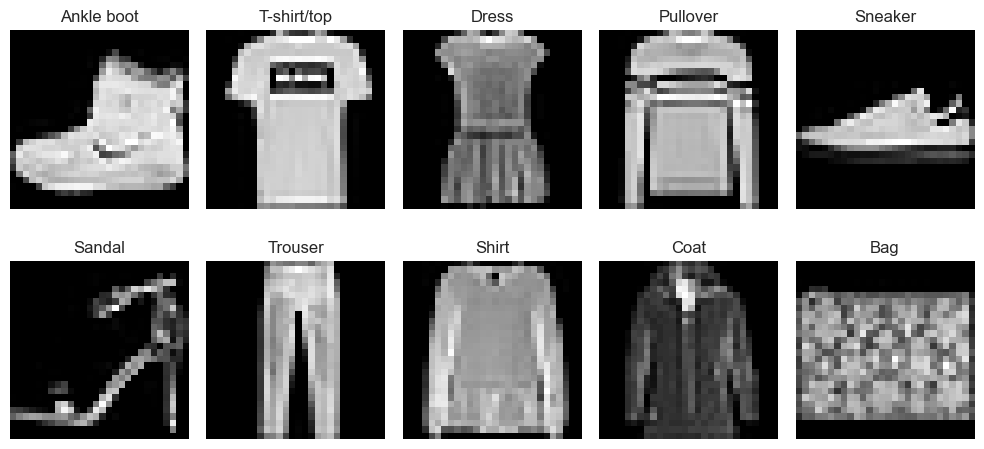

In [53]:
np.random.seed(0)
random.seed(0)

# Load our dataset
train_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()  # converts images to PyTorch tensors, scaled to [0,1]
)

test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# Extract numpy arrays for visualization or preprocessing
train_images = train_dataset.data.numpy()       # shape (60000, 28, 28)
train_labels = train_dataset.targets.numpy()    # shape (60000,)
test_images = test_dataset.data.numpy()         # shape (10000, 28, 28)
test_labels = test_dataset.targets.numpy()      # shape (10000,)

print("Train images:", train_images.shape)
print("Test images:", test_images.shape)

# Define label names
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Display one sample image for each of the 10 categories
plt.figure(figsize=(10, 5))

shown_labels = set()

i = 0
for idx, label in enumerate(train_labels):
    if label not in shown_labels:
        shown_labels.add(label)
        plt.subplot(2, 5, len(shown_labels))
        plt.imshow(train_images[idx], cmap="gray")
        plt.title(class_names[label])
        plt.axis("off")
    if len(shown_labels) == 10:
        break

plt.tight_layout()
plt.show()

The above are sample images of the data contained in our fashion-MNIST dataset—one of each category. Each observation is a greyscale image of a fashion item.

Note that the dataset is already split into training (60,000 observations) and testing (10,000 observations) data. As such, we can skip the preprocessing step of splitting the dataset that we have done in other algorithm applications.

In [54]:
# Flattening images
X_train = flatten_images(train_images)
X_test  = flatten_images(test_images)


print("Flattened X_train:", X_train.shape)
print("Flattened X_test:", X_test.shape)

Flattened X_train: (60000, 784)
Flattened X_test: (10000, 784)


Now we can "flatten" our images from a spatial layout into 2D numpy arrays so that they can be used by our distance based algorithms. Note that no information is lost in this process, it has just been reformatted into a form that can be more easily applied to neural network learning.

In [55]:
# Standardizing the data


min_, range_ = minmax_fit(X_train)
X_train_scaled = minmax_transform(X_train, min_, range_)
X_test_scaled  = minmax_transform(X_test, min_, range_)


print("Shapes after standardization:")
print("  X_train_scaled:", X_train_scaled.shape)
print("  X_test_scaled: ", X_test_scaled.shape)

Shapes after standardization:
  X_train_scaled: (60000, 784)
  X_test_scaled:  (10000, 784)


We can now rescale observations in our dataset to a fixed range in the interval [0,1] to ensure that all observations are considered equally when the gradient descent is being calculated. Compressing our pixel data to smaller values also helps improve efficiency and speed to convergence.

### Training

In [56]:
n_inputs = X_train_scaled.shape[1]
n_classes = len(np.unique(train_labels))

In [57]:
# Initializing our neural network

model = NeuralNetwork(
   n_inputs=n_inputs,
   hidden_size=256,
   task="multiclass_classification",
   n_classes=n_classes,
   learning_rate=0.01,
   batch_size=64,
   max_epochs=20,
   random_state=0
)

print(n_inputs)
print(n_classes)

784
10


We are now ready to initialize our neural network. Each image is represented by 784 pixel values, which we previously compressed into a 2D numpy array. Each of those images are passed through a set of 256 neurons that compute a weighted combination and fire according to a ReLu activation. In the final output layer, the output from the neurons classifies the observation into one of 10 of the clothing categories that comprise our dataset.

In a ReLu activation, the neuron outputs 0 for any negative input and returns the input itself for any positive value. Compared to a sigmoid activation, the ReLu is more sparse, meaning that we are able to effectively give greater weight to meaningful data.


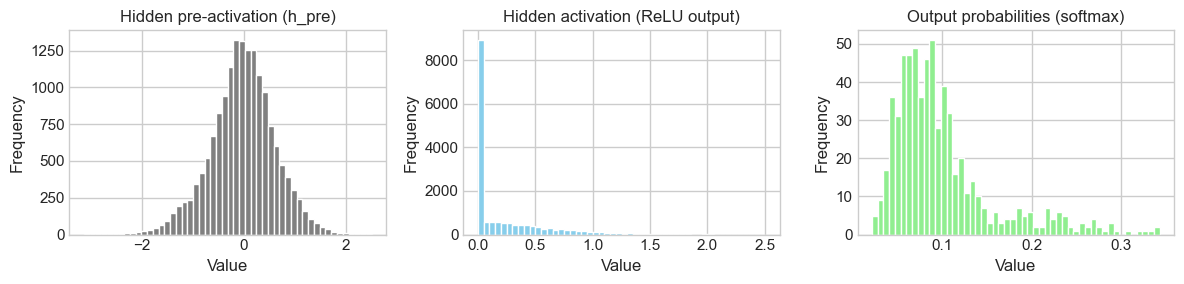

In [58]:
# Feedforward phase

X_batch = X_train_scaled[:64]

h_pre, h_act, logits, probs = model._forward(X_batch)

plt.style.use("seaborn-v0_8-whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].hist(h_pre.ravel(), bins=50, color='gray')
axes[0].set_title("Hidden pre-activation (h_pre)")
axes[1].hist(h_act.ravel(), bins=50, color='skyblue')
axes[1].set_title("Hidden activation (ReLU output)")
axes[2].hist(probs.ravel(), bins=50, color='lightgreen')
axes[2].set_title("Output probabilities (softmax)")
for ax in axes: ax.set_xlabel("Value"); ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()


For the sake of illustration, let us take a batch of 64 images from the training set.

During the feedforward phase, images are passed through the network to produce predictions. Each image is first multiplied by the network’s learned weight matrix and added to a bias term to create  pre-activations. These are then passed through our ReLU activation function. Then, those activated outputs are linearly combined in the output layer to produce unnormalized class scores called logits. Finally, we can use a softmax function converts these logits into probabilities representing the model’s confidence of prediction across the ten clothing categories.

In [59]:
# Computing the loss for the batch

y_batch = train_labels[:64]

batch_loss = model._cross_entropy_loss(probs, y_batch)
print("Batch loss:", batch_loss)

Batch loss: 2.559461609159844


From our relatively high loss value, we can conclude that at this early stage of our neural network, the randomly initialized weights of the network are unable to leverage the data to make effective predictions.

In [60]:
# Backpropagation and Feed-Forward phase

# Compute gradients 
dW1, db1, dW2, db2 = model._backward_classification(
    X=X_batch,
    y=y_batch,
    h_pre=h_pre,
    h_act=h_act,
    probs=probs
)

old_loss = batch_loss

# Apply ogradient descent update
model._apply_gradients(dW1, db1, dW2, db2)

# Run new forward pass with updated weights
h_pre2, h_act2, logits2, probs2 = model._forward(X_batch)

# Recompute loss after the weight update
new_loss = model._cross_entropy_loss(probs2, y_batch)


Here, we compute the gradients using backpropagation to determine how much each weight contributed to the overall error. Then, we are able to use stochastic gradient descent to adjust the weights in a manner that reduces the loss. After updating the weights, we can perform another forward pass to measure our new loss.

In [61]:
print(f"Old loss: {old_loss:.6f}")
print(f"New loss: {new_loss:.6f}")
print(f"Loss delta: {old_loss - new_loss:.6f}")

Old loss: 2.559462
New loss: 2.478754
Loss delta: 0.080707


We can see that the new loss value is lower than our old loss, suggesting our neural network has learned from this passthrough. 

By training over the entire training set instead of a set batch and over multiple epochs, we can effectively increase the accuracy of classification predictions from our neural network.

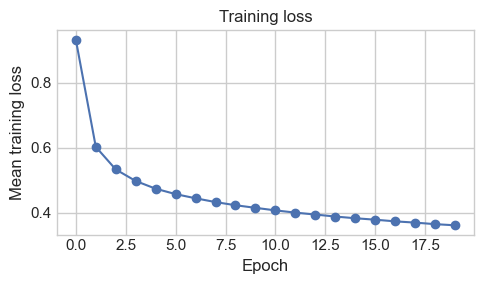

In [62]:
# Train network on the full training set
model.train(X_train_scaled, train_labels)

plt.figure(figsize=(5,3))
plt.plot(model.loss_history_, marker="o")
plt.xlabel("Epoch"); plt.ylabel("Mean training loss"); plt.title("Training loss")
plt.tight_layout(); plt.show()

As initialized, our neural network trains for 20 epochs. As training progresses, the average training loss continuously decreases, suggesting that the network is continuously learning from the data to improve the accuracy of its predictions.

The improvement with each successive epoch of training become smaller, which is typical of gradient descent based learning algorithms.

In [63]:
# Accuracy
train_acc = model.score(X_train_scaled, train_labels)
test_acc  = model.score(X_test_scaled,  test_labels)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Loss
train_probs = model.predict_proba(X_train_scaled)
train_ce_loss = model._cross_entropy_loss(train_probs, train_labels)
test_probs = model.predict_proba(X_test_scaled)
test_ce_loss = model._cross_entropy_loss(test_probs, test_labels)

print(f"Train cross-entropy loss: {train_ce_loss:.4f}")
print(f"Test cross-entropy loss: {test_ce_loss:.4f}")

Train accuracy: 0.8768
Test accuracy: 0.8589
Train cross-entropy loss: 0.3581
Test cross-entropy loss: 0.4028


After training on the full training set, we can test our trained neural network on the test data. We find that the neural network performs well both on test accuracy, with ~86% accuracy, and on cross-entropy loss, with a test loss of ~0.4.

In [67]:
idx = np.random.choice(len(X_test_scaled), 5, replace=False)

probs  = model.predict_proba(X_test_scaled[idx])
y_pred = probs.argmax(axis=1)

for i, (p, t) in enumerate(zip(y_pred, test_labels[idx])):
    print(f"Sample {idx[i]}: pred={class_names[p]} | true={class_names[t]}")

Sample 3583: pred=Sneaker | true=Sneaker
Sample 6348: pred=Ankle boot | true=Ankle boot
Sample 6008: pred=T-shirt/top | true=Shirt
Sample 813: pred=Bag | true=Bag
Sample 2438: pred=Pullover | true=Pullover


We can now make some sample predictions using our trained neural network. Out of a random sample of 5 test images, we can see that it misclassifies sample 6008 as a T-shirt/top when it is actually a Shirt. Given the large visual similarities between the two clothing types in this case, as well as the relatively high accuracy of predictions generally, we can conclude that our network has learned the major patterns present in our test images and is able to produce effective predictions.

Further tuning on the learning rate, batch sizes, and hidden layer sizes may allow the model to achieve even greater prediction accuracy.